In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Chamod Peiris\Downloads\rfe_metrics_curcumin_al.csv")
df.head(2)

,Model,n_features,Selected_Features,Pred_MAE,Pred_MSE,Pred_R2,Pred_RMSE,Test MAE,Test MSE,Test R2,Test RMSE
0,similarity_dfs_seg02_atom_pair_tanimoto,2048,"morgan_0, morgan_1, morgan_2, morgan_3, morgan...",0.125221,0.025759,0.32931,0.160497,0.078761,0.013791,0.954727,0.117434
1,similarity_dfs_seg02_atom_pair_tanimoto,1920,"morgan_1, morgan_2, morgan_3, morgan_4, morgan...",0.125221,0.025759,0.32931,0.160497,0.078761,0.013791,0.954727,0.117434


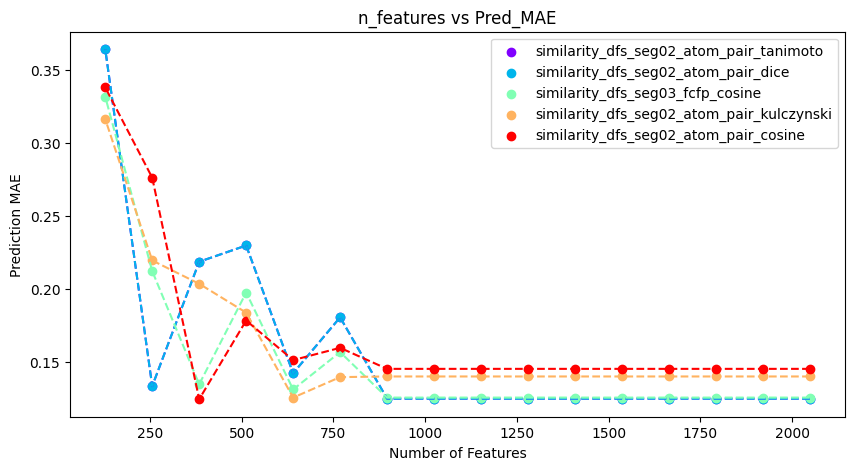

Model: similarity_dfs_seg02_atom_pair_cosine, n_features: 384, Pred_MAE: 0.124821436
Selected Features: morgan_1, morgan_9, morgan_11, morgan_14, morgan_18, morgan_24, morgan_34, morgan_40, morgan_53, morgan_62, morgan_66, morgan_76, morgan_79, morgan_80, morgan_84, morgan_87, morgan_92, morgan_95, morgan_97, morgan_102, morgan_105, morgan_106, morgan_107, morgan_111, morgan_113, morgan_114, morgan_115, morgan_122, morgan_127, morgan_130, morgan_150, morgan_155, morgan_160, morgan_162, morgan_164, morgan_180, morgan_190, morgan_191, morgan_193, morgan_212, morgan_213, morgan_216, morgan_219, morgan_220, morgan_228, morgan_240, morgan_245, morgan_248, morgan_254, morgan_261, morgan_267, morgan_269, morgan_271, morgan_281, morgan_283, morgan_288, morgan_293, morgan_302, morgan_307, morgan_310, morgan_313, morgan_314, morgan_315, morgan_318, morgan_319, morgan_320, morgan_323, morgan_324, morgan_326, morgan_338, morgan_340, morgan_346, morgan_350, morgan_352, morgan_353, morgan_356, morga

In [3]:
# Get unique models
models = df['Model'].unique()

# Create a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

plt.figure(figsize=(10, 5))

# Plot each model with a different color
for model, color in zip(models, colors):
    subset = df[df['Model'] == model]
    plt.scatter(subset['n_features'], subset['Pred_MAE'],
                label=model, color=color)
    plt.plot(subset['n_features'], subset['Pred_MAE'], linestyle='--', color=color)

plt.xlabel('Number of Features')
plt.ylabel('Prediction MAE')
plt.legend()
plt.title('n_features vs Pred_MAE')
plt.show()

# Find the 5 rows with the lowest Pred_MAE
lowest_mae_rows = df.nsmallest(5, 'Pred_MAE')

# Print the model, n_features, and Pred_MAE of the rows with the lowest Pred_MAE
for index, row in lowest_mae_rows.iterrows():
    print(f"Model: {row['Model']}, n_features: {row['n_features']}, Pred_MAE: {row['Pred_MAE']}")
    # Print the selected features of the row with the lowest Pred_MAE
    print(f"Selected Features: {row['Selected_Features']}\n")

In [5]:
# Filter the dataframe for rows where n_features is less than 1000
filtered_df = df[df['n_features'] < 890]

# Find the 5 rows with the lowest Pred_MAE
lowest_mae_filtered_rows = filtered_df.nsmallest(5, 'Pred_MAE')

# Print the model, n_features, and Pred_MAE of the rows with the lowest Pred_MAE
for index, row in lowest_mae_filtered_rows.iterrows():
    print(f"Model: {row['Model']}, n_features: {row['n_features']}, Pred_MAE: {row['Pred_MAE']}")
    # Print the selected features of the row with the lowest Pred_MAE
    print(f"Selected Features: {row['Selected_Features']}\n")

Model: similarity_dfs_seg02_atom_pair_cosine, n_features: 384, Pred_MAE: 0.124821436
Selected Features: morgan_1, morgan_9, morgan_11, morgan_14, morgan_18, morgan_24, morgan_34, morgan_40, morgan_53, morgan_62, morgan_66, morgan_76, morgan_79, morgan_80, morgan_84, morgan_87, morgan_92, morgan_95, morgan_97, morgan_102, morgan_105, morgan_106, morgan_107, morgan_111, morgan_113, morgan_114, morgan_115, morgan_122, morgan_127, morgan_130, morgan_150, morgan_155, morgan_160, morgan_162, morgan_164, morgan_180, morgan_190, morgan_191, morgan_193, morgan_212, morgan_213, morgan_216, morgan_219, morgan_220, morgan_228, morgan_240, morgan_245, morgan_248, morgan_254, morgan_261, morgan_267, morgan_269, morgan_271, morgan_281, morgan_283, morgan_288, morgan_293, morgan_302, morgan_307, morgan_310, morgan_313, morgan_314, morgan_315, morgan_318, morgan_319, morgan_320, morgan_323, morgan_324, morgan_326, morgan_338, morgan_340, morgan_346, morgan_350, morgan_352, morgan_353, morgan_356, morga

In [7]:
%%time
%reset -f

import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, rdMolDescriptors
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# apply morgan fingerprint to curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair','fcfp']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)

    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)

        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))

            # Filter top 50% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.50)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]

            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]

            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

processed_similarity_dfs = {}

for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()

    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)

    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (6481, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (6394, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (6365, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (6363, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (6361, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (6384, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (6363, 4)
Generated dataframe for segment seg01, fingerprint fcfp, similarity tanimoto: shape (6375, 4)
Generated dataframe for segment seg01, fingerprint fcfp, similarity cosine: shape (6482, 4)
Generated dataframe for segment seg01, fin

In [10]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import math

# Mappings
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint',
    'fcfp': 'FCFP Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

results = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")

    X = df.iloc[:, 4:]
    y = df['GAP_calc']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_squared_error(y_train, y_train_pred)
    test_mae = mean_squared_error(y_test, y_test_pred)

    parts = combination.split('_')

    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]
        fingerprint_type_key = '_'.join(parts[1:3])
        similarity_method_key = parts[3]
    else:
        segment_key = parts[0]
        fingerprint_type_key = parts[1]
        similarity_method_key = parts[2]

    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)

    results.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae
    })

    print(f"Done processing {combination} with Test R^2 score: {test_r2} and Test RMSE: {test_rmse}")

final_results = pd.DataFrame(results)
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Scripts_Init\72modelresultsInit.csv", index=False)
final_results.head()

Processing seg01_morgan_tanimoto...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 5092, number of used features: 884
[LightGBM] [Info] Start training from score 2.759931
Done processing seg01_morgan_tanimoto with Test R^2 score: 0.932981901802245 and Test RMSE: 0.1439929023646389
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 5184, number of used features: 909
[LightGBM] [Info] Start training from score 2.761134
Done pr

,Segment,Fingerprint Type,Similarity Method,Train R2 Score,Test R2 Score,Train RMSE,Test RMSE,Train MAE,Test MAE
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.998860,0.932982,0.018657,0.143993,0.000348,0.020734
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.999035,0.935176,0.016938,0.138158,0.000287,0.019088
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.999045,0.937364,0.016762,0.132365,0.000281,0.017520
3,Segment 01,Morgan Fingerprint,Dice Similarity,0.998860,0.932982,0.018657,0.143993,0.000348,0.020734
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.999317,0.961417,0.014069,0.105649,0.000198,0.011162


In [8]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import math

# Mappings
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint',
    'fcfp': 'FCFP Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

results_pred = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")

    X = df.iloc[:, 4:]
    y = df['GAP_calc']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)

    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])

    mae_pred = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_pred = math.sqrt(mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']))
    r2_pred = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

    parts = combination.split('_')

    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]
        fingerprint_type_key = '_'.join(parts[1:3])
        similarity_method_key = parts[3]
    else:
        segment_key = parts[0]
        fingerprint_type_key = parts[1]
        similarity_method_key = parts[2]

    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)

    results_pred.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'MAE': mae_pred,
        'RMSE': rmse_pred,
        'R2': r2_pred
    })

    print(f"Done processing {combination} with Test R^2 score: {r2_pred} and Test RMSE: {rmse_pred}")

final_results_pred = pd.DataFrame(results_pred)
final_results_pred.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Scripts_Init\72modelresults.csv", index=False)
final_results_pred.head()

Processing seg01_morgan_tanimoto...


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Chamod Peiris\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1768
[LightGBM] [Info] Number of data points in the train set: 5092, number of used features: 884
[LightGBM] [Info] Start training from score 2.759931
Done processing seg01_morgan_tanimoto with Test R^2 score: -2.814471792748593 and Test RMSE: 0.382757764759505
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1818
[LightGBM] [Info] Number of data points in the train set: 5184, number of used features: 909
[LightGBM] [Info] Start training from score 2.761134
Done processing seg01_morgan_cosine with Te

,Segment,Fingerprint Type,Similarity Method,MAE,RMSE,R2
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.343007,0.382758,-2.814472
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.191589,0.212693,-0.177862
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.175436,0.209793,-0.145955
3,Segment 01,Morgan Fingerprint,Dice Similarity,0.343007,0.382758,-2.814472
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.198559,0.232492,-0.407355


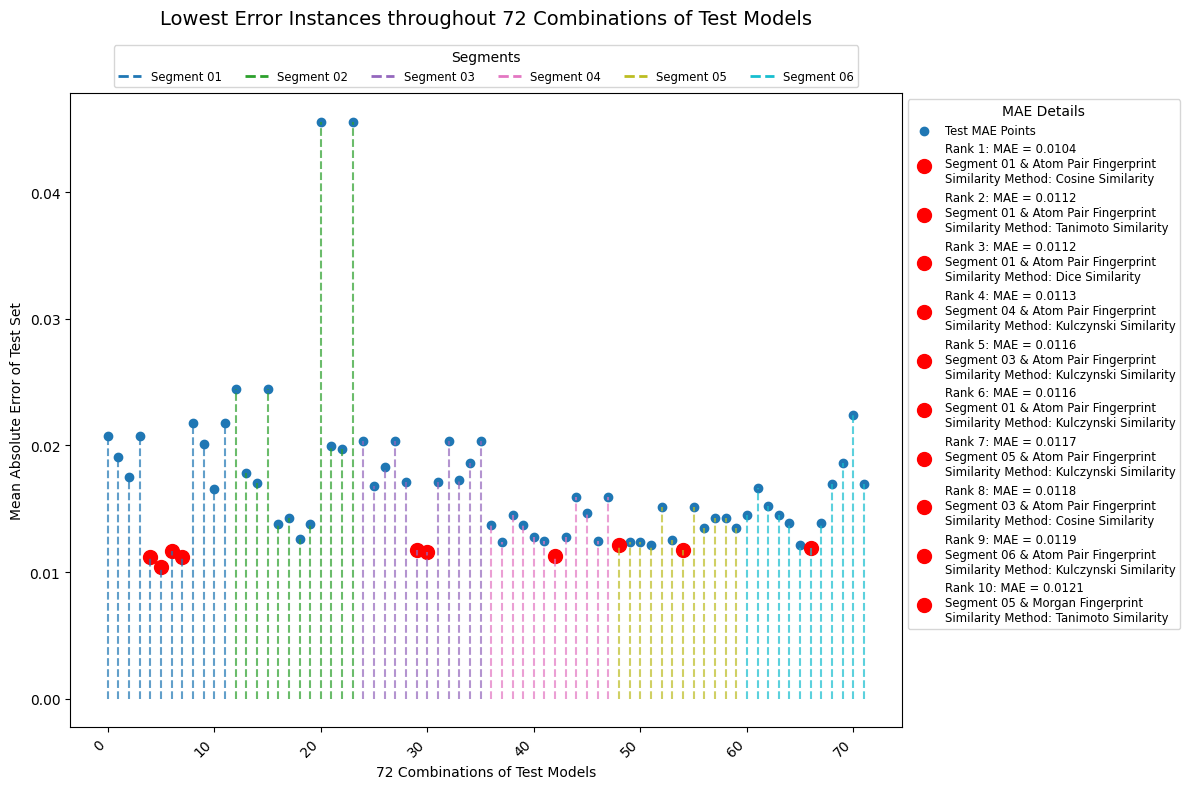

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.lines import Line2D

# Colormap for segments
unique_segments = final_results['Segment'].unique()
segment_color_map = {segment: color for segment, color in zip(unique_segments, cm.tab10(np.linspace(0, 1, len(unique_segments))))}

# Five Minimum Error Points
lowest_mae_indices = final_results['Test MAE'].nsmallest(10).index
lowest_mae_data = final_results.loc[lowest_mae_indices]

plt.figure(figsize=(12, 8))
plt.scatter(final_results.index, final_results['Test MAE'], marker='o', label="Test MAE Points")

# Highlight the five lowest points
for i, index in enumerate(lowest_mae_indices):
    data = final_results.loc[index]
    plt.scatter(
        index, data['Test MAE'], color='red', s=100,
        label=f"Rank {i+1}: MAE = {data['Test MAE']:.4f}\n"
              f"{data['Segment']} & {data['Fingerprint Type']}\n"
              f"Similarity Method: {data['Similarity Method']}"
    )

# Vertical Line Mapping
for i in range(len(final_results)):
    segment = final_results['Segment'].iloc[i]
    color = segment_color_map[segment]
    plt.vlines(
        x=i,
        ymin=0,
        ymax=final_results['Test MAE'][i],
        colors=color,
        linestyles='dashed',
        alpha=0.7,
    )

# Legend 1: Segments (color-coded lines)
segment_legend_handles = [
    Line2D([0], [0], color=color, linestyle='dashed', lw=2, label=segment)
    for segment, color in segment_color_map.items()
]
legend1 = plt.legend(
    handles=segment_legend_handles,
    title="Segments",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.085),
    fontsize='small',
    ncol=6,
)

# Legend 2: MAE Details (scatter point and minimum points)
legend2 = plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',
    title='MAE Details'
)

# Add the first legend manually back to the plot
plt.gca().add_artist(legend1)

# Customize plot
plt.xlabel('72 Combinations of Test Models')
plt.ylabel('Mean Absolute Error of Test Set')
plt.title('Lowest Error Instances throughout 72 Combinations of Test Models', pad=50, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

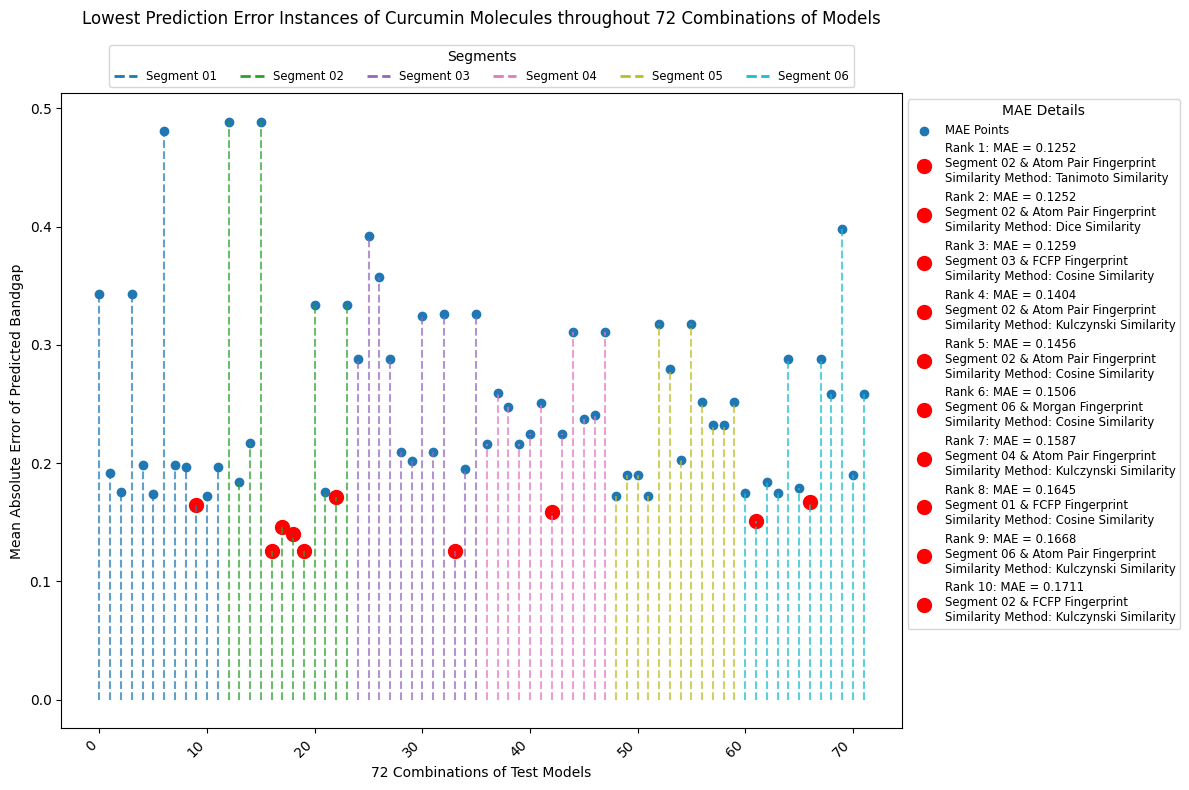

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.lines import Line2D

# Colormap for segments
unique_segments = final_results_pred['Segment'].unique()
segment_color_map = {segment: color for segment, color in zip(unique_segments, cm.tab10(np.linspace(0, 1, len(unique_segments))))}

# Five Minimum Error Points
lowest_mae_indices = final_results_pred['MAE'].nsmallest(10).index
lowest_mae_data = final_results_pred.loc[lowest_mae_indices]

plt.figure(figsize=(12, 8))
plt.scatter(final_results_pred.index, final_results_pred['MAE'], marker='o', label="MAE Points")

# Highlight the five lowest points
for i, index in enumerate(lowest_mae_indices):
    data = final_results_pred.loc[index]
    plt.scatter(
        index, data['MAE'], color='red', s=100,
        label=f"Rank {i+1}: MAE = {data['MAE']:.4f}\n"
              f"{data['Segment']} & {data['Fingerprint Type']}\n"
              f"Similarity Method: {data['Similarity Method']}"
    )

# Vertical Line Mapping
for i in range(len(final_results_pred)):
    segment = final_results_pred['Segment'].iloc[i]
    color = segment_color_map[segment]
    plt.vlines(
        x=i,
        ymin=0,
        ymax=final_results_pred['MAE'][i],
        colors=color,
        linestyles='dashed',
        alpha=0.7,
    )

# Legend 1: Segments (color-coded lines)
segment_legend_handles = [
    Line2D([0], [0], color=color, linestyle='dashed', lw=2, label=segment)
    for segment, color in segment_color_map.items()
]
legend1 = plt.legend(
    handles=segment_legend_handles,
    title="Segments",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.085),
    fontsize='small',
    ncol=6,
)

# Legend 2: MAE Details (scatter point and minimum points)
legend2 = plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 1),
    fontsize='small',
    title='MAE Details'
)

# Add the first legend manually back to the plot
plt.gca().add_artist(legend1)

# Customize plot
plt.xlabel('72 Combinations of Test Models')
plt.ylabel('Mean Absolute Error of Predicted Bandgap')
plt.title('Lowest Prediction Error Instances of Curcumin Molecules throughout 72 Combinations of Models', pad=50, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

___________________________________________________________________
Processing seg02_atom_pair_cosine
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 881
[LightGBM] [Info] Start training from score 2.674072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1762
[LightGBM] [Info] Number of data points in the train set: 5156, number of used features: 881
[LightGBM] [Info] Start training from score 2.674072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Model seg02_atom_pair_cosine
MAE Value: 0.08012 & RMSE Value: 0.11856
Prediction --> model MAE: 0.10190 & RMSE: 0.13521
Prediction --> model R2 Score: 0.0091
___________________________________________________________________


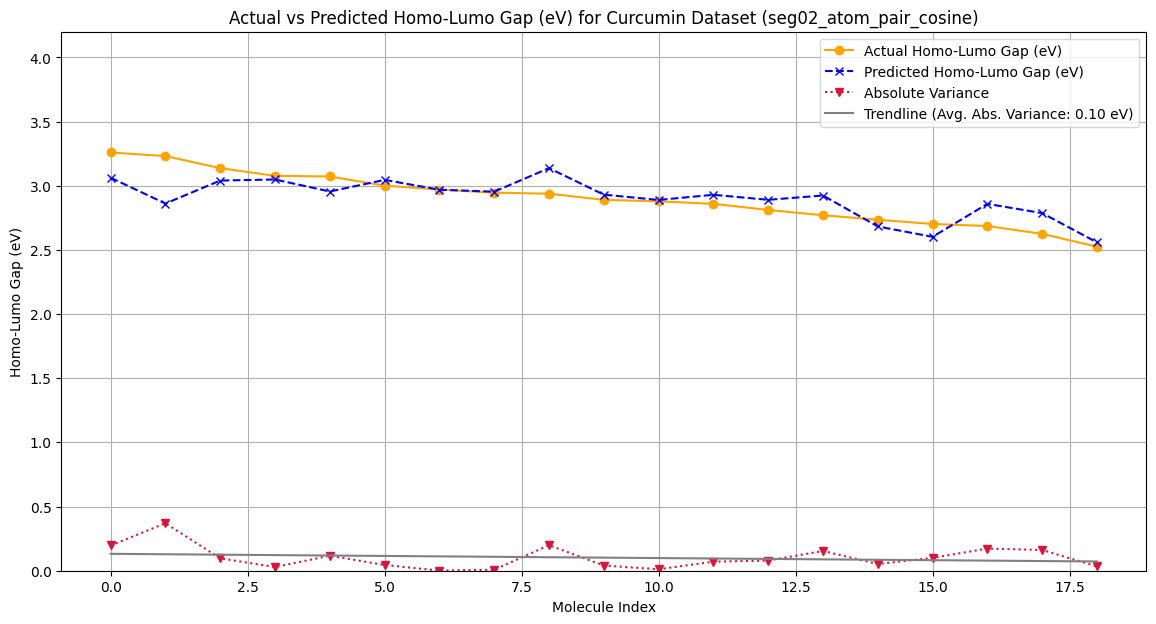

CPU times: total: 7h 13min 39s
Wall time: 29min 33s


In [15]:
%%time

import pandas as pd
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# List of best models and their corresponding DataFrame keys
best_models_all_segments = [
    "seg02_atom_pair_cosine"
]

# Loop over each model
for model_name in best_models_all_segments:
    print("___________________________________________________________________")
    print(f"Processing {model_name}")
    
    # Load the respective DataFrame
    df = processed_similarity_dfs[model_name]
    X = df.iloc[:, 4:]  # Features from the 4th column onwards
    y = df['GAP_calc']  # Target variable

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LightGBM parameters and model initialization
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)

    # RFE for feature selection
    n_features_to_select = 810
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model using the selected features
    model.fit(X_train[selected_features], y_train)
    y_pred_test = model.predict(X_test[selected_features])
    
    # Calculate metrics for the test set
    mae_model = mean_absolute_error(y_test, y_pred_test)
    rmse_model = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_model = model.score(X_test[selected_features], y_test)
    
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    
    # Predict on the curcumin dataset using the same selected features
    curcumin_X = curcumin_df_mf[selected_features]
    curcumin_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_X)

    # Sort by actual Homo-Lumo Gap for visualization
    curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

    # Calculate evaluation metrics for curcumin predictions
    mae_predict = mean_absolute_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], squared=False)
    r2_predict = model.score(curcumin_X, curcumin_df_mf['Homo-Lumo Gap (eV)'])

    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")

    # Calculate absolute variance and average variance
    curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Pred']).abs()
    average_variance = curcumin_df_mf['absolute_variance'].mean()
    
    # Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
    plt.figure(figsize=(14, 7))

    # Plot actual and predicted values
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

    # Plot absolute variance
    plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

    # Plot trendline for absolute variance
    x_vals = np.arange(len(curcumin_df_mf))
    trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
    plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

    # Customize the plot
    plt.xlabel('Molecule Index')
    plt.ylabel('Homo-Lumo Gap (eV)')
    plt.title(f'Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset ({model_name})')
    plt.ylim(0, 4.2)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [23]:
print(r2_model)

0.9537829372595051


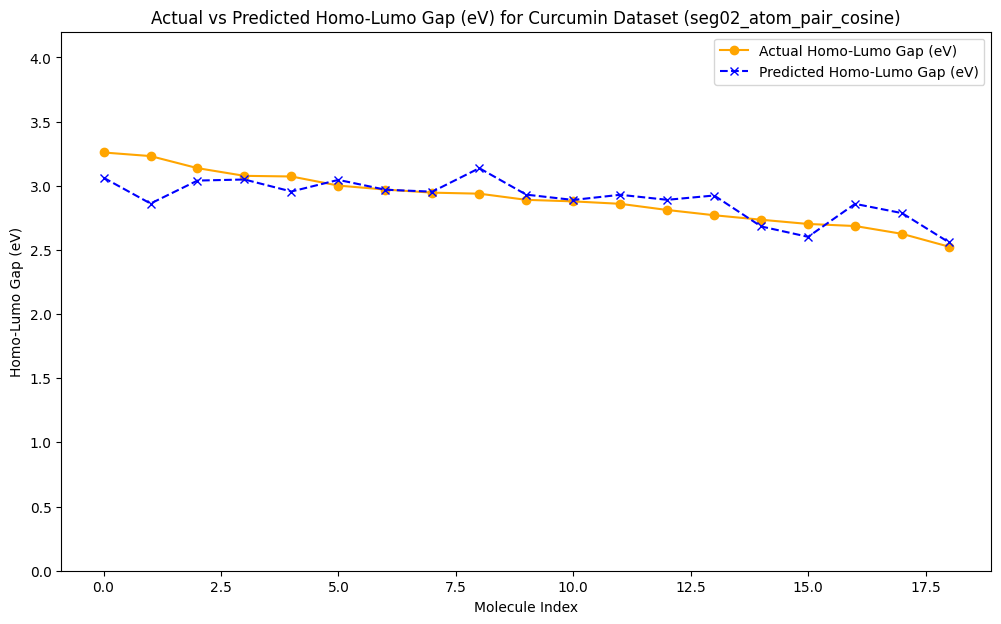

In [21]:
# Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
plt.figure(figsize=(12, 7))

plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

# Customize the plot
plt.xlabel('Molecule Index')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.title(f'Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset ({model_name})')
plt.ylim(0, 4.2)
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
%%time

import pandas as pd
from sklearn.feature_selection import RFE
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# List of best models and their corresponding DataFrame keys
best_models_all_segments = [
    "seg02_atom_pair_tanimoto",
    "seg02_atom_pair_dice",
    "seg03_fcfp_cosine",
    "seg02_atom_pair_kulczynski",
    "seg02_atom_pair_cosine"
]

# Loop over each model
for model_name in best_models_all_segments:
    print("___________________________________________________________________")
    print(f"Processing {model_name}")
    
    # Load the respective DataFrame
    df = processed_similarity_dfs[model_name]
    X = df.iloc[:, 4:]  # Features from the 4th column onwards
    y = df['GAP_calc']  # Target variable

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # LightGBM parameters and model initialization
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)

    # RFE for feature selection
    n_features_to_select = 810
    rfe = RFE(model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    
    # Train the model using the selected features
    model.fit(X_train[selected_features], y_train)
    y_pred_test = model.predict(X_test[selected_features])
    
    # Calculate metrics for the test set
    mae_model = mean_absolute_error(y_test, y_pred_test)
    rmse_model = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_model = model.score(X_test[selected_features], y_test)
    
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    
    # Predict on the curcumin dataset using the same selected features
    curcumin_X = curcumin_df_mf[selected_features]
    curcumin_df_mf['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_X)

    # Sort by actual Homo-Lumo Gap for visualization
    curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

    # Calculate evaluation metrics for curcumin predictions
    mae_predict = mean_absolute_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf['Homo-Lumo Gap (eV)'], curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], squared=False)
    r2_predict = model.score(curcumin_X, curcumin_df_mf['Homo-Lumo Gap (eV)'])

    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")

    # Calculate absolute variance and average variance
    curcumin_df_mf['absolute_variance'] = (curcumin_df_mf['Homo-Lumo Gap (eV)'] - curcumin_df_mf['Homo-Lumo Gap (eV) Pred']).abs()
    average_variance = curcumin_df_mf['absolute_variance'].mean()
    
    # Optional: Plot actual vs predicted for curcumin dataset along with absolute variance
    plt.figure(figsize=(14, 7))

    # Plot actual and predicted values
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV)'], label='Actual Homo-Lumo Gap (eV)', marker='o', color='orange')
    plt.plot(curcumin_df_mf['Homo-Lumo Gap (eV) Pred'], label='Predicted Homo-Lumo Gap (eV)', marker='x', linestyle='--', color='blue')

    # Plot absolute variance
    plt.plot(curcumin_df_mf['absolute_variance'], label='Absolute Variance', marker='v', linestyle=':', color='crimson')

    # Plot trendline for absolute variance
    x_vals = np.arange(len(curcumin_df_mf))
    trendline = np.polyval(np.polyfit(x_vals, curcumin_df_mf['absolute_variance'], 1), x_vals)
    plt.plot(trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

    # Customize the plot
    plt.xlabel('Molecule Index')
    plt.ylabel('Homo-Lumo Gap (eV)')
    plt.title(f'Actual vs Predicted Homo-Lumo Gap (eV) for Curcumin Dataset ({model_name})')
    plt.ylim(0, 4.2)
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()